**Homework 2: Convolutional Networks**

---


*Due date: 27.03.2019, presented at the lab*

*Total: 100 points: min(100, score)*

For this homework you will design and train a convolutional network capable of counting the digits in an image. You will get a dataset of 5000 training images and 1000 testing images, each of size 100x100. These images are formed by placing N (1 to 5) digits from the MNIST dataset (28x28 digits) onto a noisy background. The goal is to predict the number of digits in the image. The dataset is found in the course Google Drive folder in mnist_count_test.pickle and mnist_count_train.pickle.

*You must implement two methods for this task:*
1. Method 1: **[50 points]**: Without training on the counting dataset. Just use a model trained to classify images on MNIST dataset. Use this model in a sliding window approach or by converting it to a fully convolutional network to predict maps representing the probability of digits being present at that location. Using this maps, with no additional training estimate the number of digits.

2. Method 2: **[80 points]**: Train a new convolutional network to predict the number of digits. Investigate the usefulness transfer learning by reusing the first part of the classification MNIST network. Train a model using parameters from the pretrained classification model and a model with all the parameters randomly initialized.

Your task is to investigate the best network architecture for this tasks, the appropriate loss (mean square error or cross-entropy), the effect of transfer learning.

**Method 1**

---



In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Training settings    
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10#10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True,drop_last=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27218705.36it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 432449.55it/s]
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7198689.79it/s]                           
8192it [00:00, 179834.60it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(4*4*no_filter2, no_neurons1)
        self.fc2 = nn.Linear(no_neurons1, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

torch.save(model.state_dict(),"mnist_cnn.pt")




Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301512
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.426127
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.216665
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.132044
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.006072
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.043226
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.062645

Test set: Average loss: 0.0677, Accuracy: 9762/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078619
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.011335
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.017006
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.199974
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.015825
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.036920
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.051368

Test set: Average loss: 0.0452, Accuracy: 9841/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.013695
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.031343
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.024958
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.0

np_dataset_large shape: (5000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)


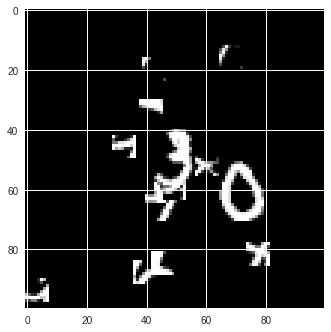

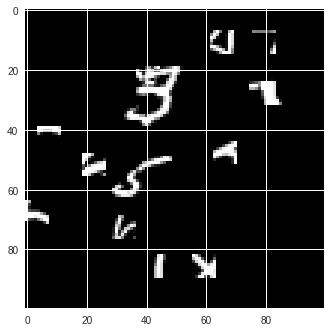

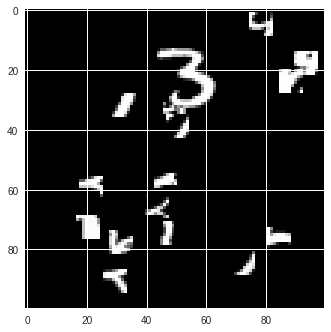

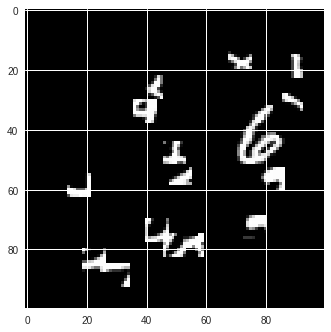

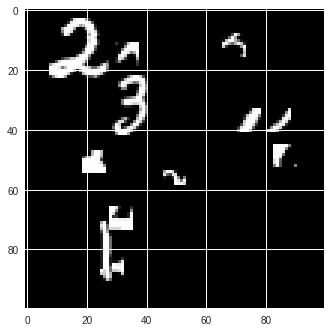

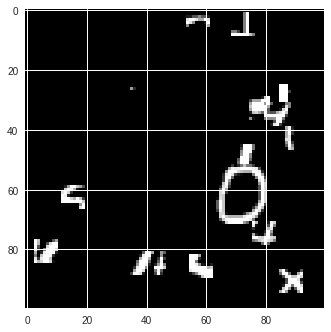

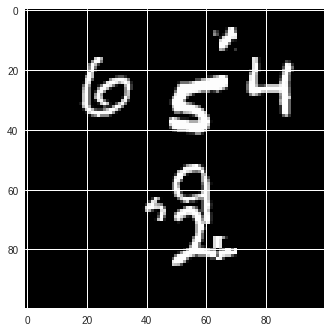

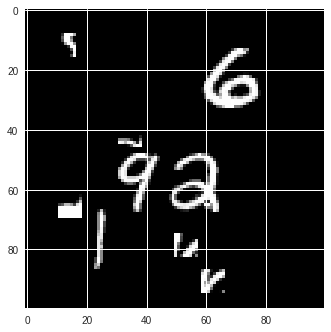

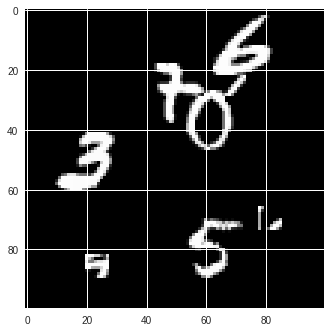

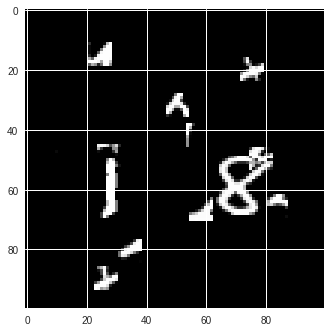

In [7]:
import pickle

def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_coords = data['no_count'].astype(np.float32)[:first_k]
  
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    iii = np_dataset_large[10+ii].reshape((100, 100))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_coords = map(torch.tensor, 
                                      (np_dataset_large, np_dataset_coords))
  dataset_large = dataset_large.to(device)
  dataset_coords = dataset_coords.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_coords)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  return large_data_loader

path_train = 'gdrive/My Drive/Colab Notebooks/Homework#2/mnist_count_train.pickle'
path_test = 'gdrive/My Drive/Colab Notebooks/Homework#2/mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)

In [0]:
# design the fully convolutional network    
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

In [9]:
# data should be in [0,1]
def preporcess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)
# define the fully_conv model
model2 = CNN_fully_conv()

# load classification model
loaded_state_dict = torch.load(PATH)

# loaded_state_dict contain the weights of the classification model
# for the fully_conv model we will use exactly the same parameters
# for the convolutional part we can directly load them as they have the same name

# we need to convert the last fully-connected layers into convolutions
# for a single neuraon we would just reshape the parameters from a vector into a kernel. 
# We just need to know what has the spatial dimmension of the original fully-connected imput
# in our case, the first fully-connected had an input of size 4x4x500, so we must use kernels of size 4x4
# the second fully-connected receives as input just a vector(1x1 spatial dimension) thus we use kernels if size 1x1
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
model2.load_state_dict(model_dict)
model2 = model2.to(device)

print(model2.parameters)

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


In [18]:
#GET BEST TRESHOLD
threshold_of_confidence = 0
test_threshold = -0.0002 # I only iterate from -0.0002 : 0.00001 : 0.0002
Accuracy = 0

nIter = 0
while test_threshold <= 0.0002:
  err = 0
  n = 0
  N = 0
  accuracy = 0
  for batch_idx, (large_imgs, target_coords) in enumerate(large_data_loader_train):

    #print(f'large_imgs shape {large_imgs.shape}')
    large_imgs = preporcess(large_imgs)
    out_prob_maps = model2(large_imgs)
    # from the 10 maps, we select the index of the strongest activation
    probs, _ = torch.sort(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0], dim=1, descending=True)
    probs = probs[:, 0:5]
    #print(f'probs shape {probs.shape}')
    count_net_output = (probs > test_threshold).sum(dim=1).float()
    # compute the error between the estimated location and the ground truth one
    mse = torch.sqrt(torch.sum((target_coords - count_net_output) * (target_coords - count_net_output)))
    err = err + mse
    n = n + 1;
    N = N + large_imgs.shape[0]
    accuracy = accuracy + torch.sum(target_coords == count_net_output)

  newAcc = accuracy.float() * 100 / N
  if newAcc > Accuracy:
    Accuracy = newAcc
    threshold_of_confidence = test_threshold
    
  test_threshold = test_threshold + 0.000001
  nIter = nIter + 1
  if nIter % 100 == 0: 
    print(f'{nIter}% ready')
    print(f'accuracy = {Accuracy}%')
    print(f'test_threshold = {test_threshold}%')
    
print(f'threshold_of_confidence = {threshold_of_confidence}')

100% ready
accuracy = 34.29487228393555%
test_threshold = -0.00010000000000000029%
200% ready
accuracy = 34.334938049316406%
test_threshold = -4.705268021997638e-19%
300% ready
accuracy = 34.334938049316406%
test_threshold = 9.999999999999935e-05%
400% ready
accuracy = 34.334938049316406%
test_threshold = 0.0001999999999999991%
threshold_of_confidence = -9.60000000000003e-05


threshold_of_confidence = -9.60000000000003e-05
error = 9.8443021774292
accuracy = 35.9375%
tensor(2., device='cuda:0')
tensor(2., device='cuda:0')
tensor(1., device='cuda:0')
tensor(3., device='cuda:0')
tensor(5., device='cuda:0')
tensor(1., device='cuda:0')
tensor(2., device='cuda:0')
tensor(1., device='cuda:0')
tensor(5., device='cuda:0')
tensor(2., device='cuda:0')
tensor(5., device='cuda:0')
tensor(3., device='cuda:0')
tensor(2., device='cuda:0')
tensor(5., device='cuda:0')
tensor(3., device='cuda:0')
tensor(5., device='cuda:0')
tensor(2., device='cuda:0')
tensor(2., device='cuda:0')
tensor(4., device='cuda:0')
tensor(4., device='cuda:0')


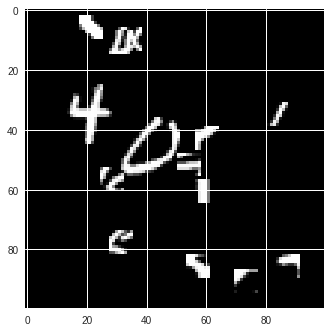

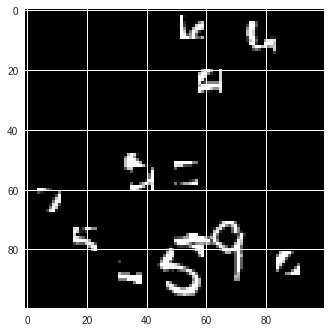

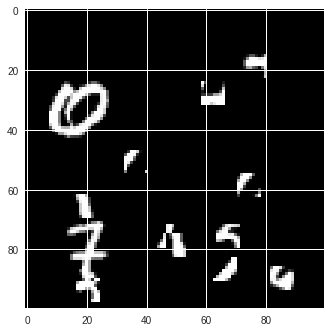

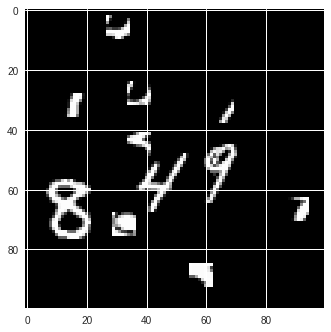

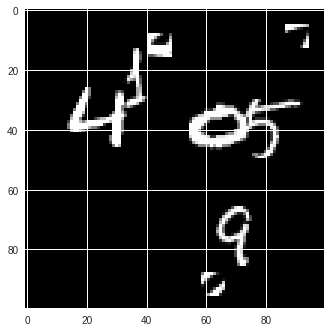

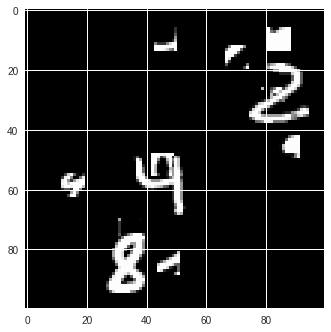

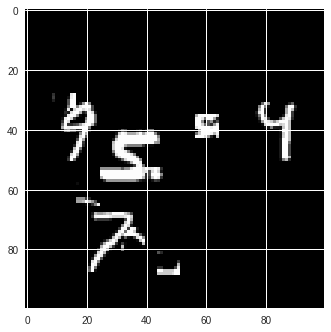

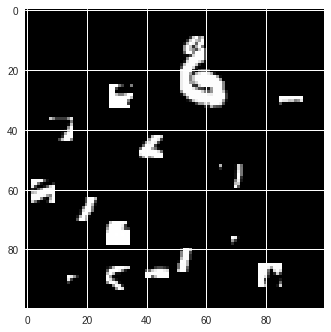

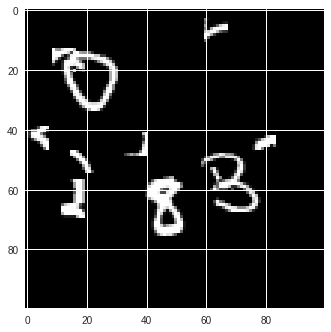

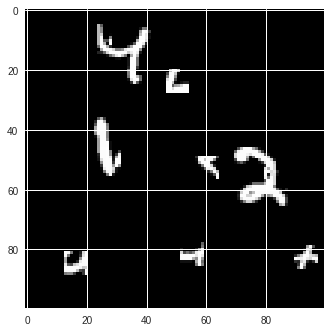

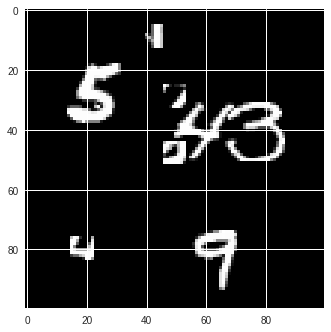

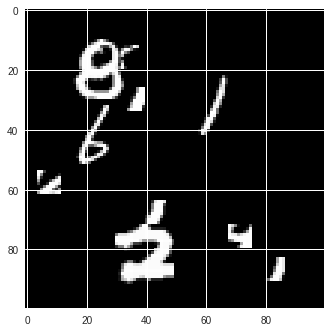

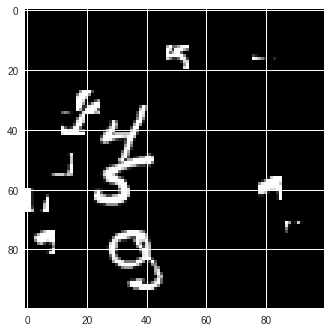

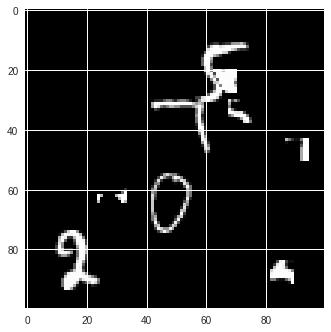

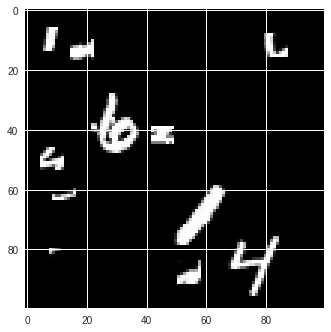

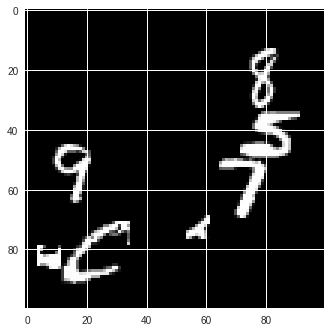

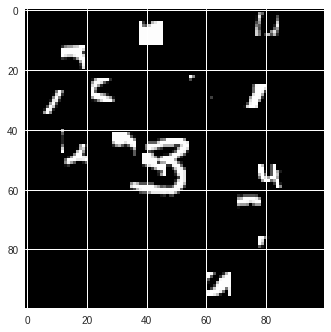

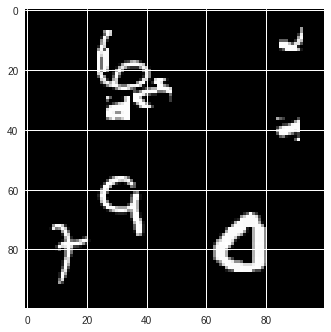

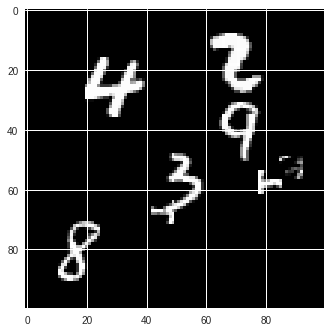

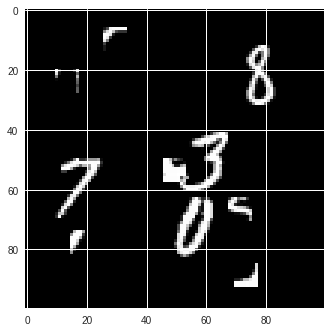

In [19]:
print(f'threshold_of_confidence = {threshold_of_confidence}')
err = 0
n = 0
N = 0
accuracy = 0
for batch_idx, (large_imgs, target_coords) in enumerate(large_data_loader_test):

  #print(f'large_imgs shape {large_imgs.shape}')
  large_imgs = preporcess(large_imgs)
  out_prob_maps = model2(large_imgs)
  # from the 10 maps, we select the first 5 indexs of the strongest activation
  probs, _ = torch.sort(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0], dim=1, descending=True)
  probs = probs[:, 0:5]
  #print(f'probs shape {probs.shape}')
  count_net_output = (probs > threshold_of_confidence).sum(dim=1).float()
  # compute the error between the estimated location and the ground truth one
  mse = torch.sqrt(torch.sum((target_coords - count_net_output) * (target_coords - count_net_output)))
  err = err + mse
  n = n + 1;
  N = N + large_imgs.shape[0]
  accuracy = accuracy + torch.sum(target_coords == count_net_output)

print(f'error = {err/n}')
print(f'accuracy = {accuracy.float() * 100 / N}%')
  
# show some examples
# the center is represented as a sqare in the image
show_figures = True
if show_figures:
  for i in range(20):
    pyplot.figure()
    img = large_imgs[i]
    print(count_net_output[i])
    pyplot.imshow(img.cpu().numpy().reshape((100, 100)), cmap = "gray")
    

**Method 2**

---



In [0]:
# design the counting network
class CNN_counting(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
      self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
      self.fully_conv2_new = nn.Conv2d(no_neurons1,5, 1)
      
      
      self.linear_loc = nn.Linear(19*19*5,1)
  def forward(self, xb):
      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)
      self.lin = self.linear_loc(self.conv_act)
      self.final = F.relu(self.lin)
      return self.final.view(-1)

In [0]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
# train localisation model
def train_localisation(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = preporcess(data)
        optimizer.zero_grad()
        output = model(data)
        # as we want to predict real numbers, from a continuous space ([0,1])
        # we use mean-square-error loss (L2 loss)
        loss = F.mse_loss(output, target)
        
        loss.backward()
        all_losses.append(loss.data.cpu().numpy())
        optimizer.step()
        if False and batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()
def test_localisation(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = preporcess(data)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
Scratch epoch: 1

Test set: Average loss: 1.8077

Scratch epoch: 2

Test set: Average loss: 1.7627

Scratch epoch: 3

Test set: Average loss: 1.7044

Scratch epoch: 4

Test set: Average loss: 1.6301

Scratch epoch: 5

Test set: Average loss: 1.5486

Scratch epoch: 6

Test set: Average loss: 1.4716

Scratch epoch: 7

Test set: Average loss: 1.3689

Scratch epoch: 8

Test set: Average loss: 1.2789

Scratch epoch: 9

Test set: Average loss: 1.1887

Scratch epoch: 10

Test set: Average loss: 1.1028

Scratch epoch: 11

Test set: Average loss: 1.0309

Scratch epoch: 12

Test set: Average loss: 0.9713

Scratch epoch: 13

Test set: Average loss: 0.9321

Scratch epoch: 14

Test set: Average loss: 0.9452

Scratch epoch: 15

Test set: Average loss: 0.8791

Scratch epoch: 16

Test set: Average loss: 0.8621

Scratch epoch: 17

Test set: Aver

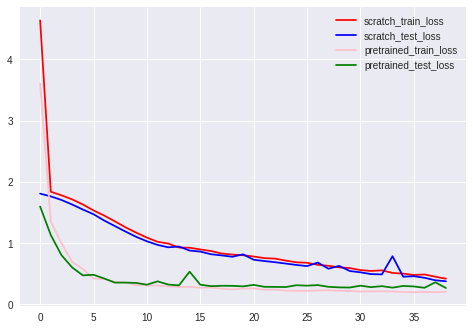

In [15]:
# save classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

# we will train 2 models, one with random initialisation, 
# one with parameters initialised from the classification network
loc_model_scratch = CNN_counting()
loc_model_pretrained = CNN_counting()

# convert the fully-connected into convolutional layers
loaded_state_dict = torch.load(PATH)
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val


loc_model_scratch = loc_model_scratch.to(device)
# load pretrained classification parameters into localisation model
loc_model_pretrained.load_state_dict(model_dict, strict=False)
loc_model_pretrained = loc_model_pretrained.to(device)


loc_model_pretrained.linear_loc.weight.data

args.lr = 0.0001
optimizer_loc_scratch = optim.SGD(
    loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)

optimizer_loc_pretrained = optim.SGD(
    loc_model_pretrained.parameters(), lr=args.lr, momentum=args.momentum)


losses_train = []
losses_test = []

for epoch in range(1, args.epochs + 30):
  
    print(f'Scratch epoch: {epoch}')
    train_loss = train_localisation(args, loc_model_scratch, device, large_data_loader_train, optimizer_loc_scratch, epoch)
    test_loss  = test_localisation(args, loc_model_scratch, device, large_data_loader_test)
    
    losses_train.append(train_loss)
    losses_test.append(test_loss)

losses_train_pre = []
losses_test_pre = []

args.lr = 0.0015
for epoch in range(1, args.epochs + 30):
    print(f'Pretrained epoch: {epoch}')
    train_loss = train_localisation(args, loc_model_pretrained, device, large_data_loader_train, optimizer_loc_pretrained, epoch)
    test_loss  = test_localisation(args, loc_model_pretrained, device, large_data_loader_test)
    
    losses_train_pre.append(train_loss)
    losses_test_pre.append(test_loss)

    
plot_loss(losses_train,'scratch_train_loss','red')
plot_loss(losses_test,'scratch_test_loss')

plot_loss(losses_train_pre,'pretrained_train_loss','pink')
plot_loss(losses_test_pre,'pretrained_test_loss','green')

In [17]:
N = 0
Acc = 0
for data_test, target_test in large_data_loader_test:
  data_test = preporcess(data_test)
  output = torch.round(loc_model_pretrained(data_test))
  n = target_test.shape[0]
  Acc = Acc + (target_test == output).sum()
  N = N + n
print(f'Accuracy_pretrained = {Acc.float() * 100 / N}%')
  
N = 0
Acc = 0
for data_test, target_test in large_data_loader_test:
  data_test = preporcess(data_test)
  output = torch.round(loc_model_scratch(data_test))
  n = target_test.shape[0]
  Acc = Acc + (target_test == output).sum()
  N = N + n
        
print(f'Accuracy_scratch = {Acc.float() * 100 / N}%')

Accuracy_pretrained = 65.41667175292969%
Accuracy_scratch = 56.97916793823242%
